do random forest training and testing

• provide accuracy, confusion matrix and classification report.

• interpret the classification report.

• Assess feature importance

• Pick one small decision tree from the random forest and explain it

• Use the top five important features to do a decision tree model analysis

In [57]:
# Imports needed for the script
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import re  # For regular expression operations (if needed)
import seaborn as sns  # Seaborn for data visualization
import matplotlib.pyplot as plt  # For plotting graphs and visualizations

# For inline plotting in Jupyter Notebooks
%matplotlib inline

# Plotly for interactive visualizations
import plotly.offline as py  
py.init_notebook_mode(connected=True)  # Initialize Plotly in notebook mode for interactive visualizations
import plotly.graph_objs as go  # Graph objects for building plots
import plotly.tools as tls  # Tools for Plotly visualizations

# Sklearn imports for machine learning tasks
from sklearn import tree  # Decision tree algorithms
from sklearn.metrics import accuracy_score  # To calculate accuracy of the model
from sklearn.model_selection import KFold  # For K-fold cross-validation
from sklearn.model_selection import cross_val_score  # To calculate cross-validation score
from sklearn.ensemble import RandomForestClassifier

# For displaying images and performing system calls
from IPython.display import Image as PImage  # To display images in Jupyter Notebook
from subprocess import check_call  # To run system commands, if needed
from PIL import Image, ImageDraw, ImageFont  # Python Imaging Library for image processing

# Loading the data
train = pd.read_csv('train.csv')  # Loading the training data from CSV file
test = pd.read_csv('test.csv')  # Loading the test data from CSV file

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']  # Storing PassengerId from the test dataset for later use

full_data = [train, test]
print(full_data)  # Displaying the first 3 rows of the training dataset to inspect the data


[     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...

In [58]:
#Prepare features and target
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# creates a list named full_data that contains both the train and test datasets.
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
#This block creates a new feature called Has_Cabin in both train and test datasets
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [59]:
#we creates a deep copy of the train dataset and stores it in a variable called original_train.
#a backup of the original data. If you later modify the train dataset and need to reference the unmodified version, you can use original_train.
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# creates a list named full_data that contains both the train and test datasets.
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
#This block creates a new feature called Has_Cabin in both train and test datasets
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [60]:
# Feature that tells whether a passenger had a cabin on the Titanic
for dataset in full_data:
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Handle missing values for Age, Fare, and Embarked
for dataset in full_data:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna('S')  # Fill missing 'Embarked' values with the most common port

    # Mapping 'Embarked' from categorical strings to integers
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping 'Sex' from categorical strings to integers
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Extract titles and group rare titles into a single category
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr',
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Mapping 'Title' from categorical strings to integers
title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
for dataset in full_data:
    dataset['Title'] = dataset['Title'].map(title_mapping).fillna(0).astype(int)

# Mapping Fare and Age into discrete intervals (binning)
for dataset in full_data:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4
    dataset['Age'] = dataset['Age'].astype(int)

# Prepare data for training
x_train = train.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)
y_train = train['Survived']
x_test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)

# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
random_forest.fit(x_train, y_train)  # Fit the model using the training data

# Predicting results for the test dataset
y_pred_rf = random_forest.predict(x_test)

# Store results in a DataFrame and export to CSV for submission
submission = pd.DataFrame({
        "PassengerId": test['PassengerId'],
        "Survived": y_pred_rf
    })
submission.to_csv('submission.csv', index=False)

In [61]:
#prepare feature and target
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)


# Create Random Forest Model

In [63]:
# After ensuring no missing values, now fit the model to x_train and y_train
# Random Forest Classifier (as an example)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=1)
random_forest.fit(x_train, train['Survived'])  # Fit model using training data

# Predict using x_test
y_pred_rf = random_forest.predict(x_test)




In [67]:
#Predict results on test data
y_pred_rf = random_forest.predict(x_test)


In [69]:
#Evaluate accuracy
train_pred_rf = random_forest.predict(x_train)
acc_random_forest=round(accuracy_score(y_train, train_pred_rf)*100, 2)

print(f"Raandom Forest Accuracy: {acc_random_forest}%")

Raandom Forest Accuracy: 84.18%


Confusion Matrix, and Classification Report

In [75]:
from sklearn.metrics import classification_report, confusion_matrix

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_train, train_pred_rf))

# Classification report
print("Classification Report:")
print(classification_report(y_train, train_pred_rf))


Confusion Matrix:
[[495  54]
 [ 87 255]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       549
           1       0.83      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



#  Interpret the Classification Report

Assess Feature Importance

In [76]:
feature_importances = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': random_forest.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)


Feature Importances:
      Feature  Importance
8       Title    0.316531
1         Sex    0.273235
0      Pclass    0.137186
6  FamilySize    0.079037
5   Has_Cabin    0.065737
3        Fare    0.052792
2         Age    0.038798
4    Embarked    0.024210
7     IsAlone    0.012474


Pick One Small Decision Tree from the Random Forest and Explain It

In [80]:
# Pick the first tree from the random forest
tree_ = random_forest.estimators_[0]

# Visualize the decision tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_, out_file=None, 
                           feature_names=x_train.columns,  
                           class_names=['Died', 'Survived'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("small_tree")


'small_tree.pdf'

Use the Top Five Important Features to Do a Decision Tree Model Analysis

In [79]:
# Get top 5 important features
top_features = feature_importances['Feature'].head(5).tolist()

# Train a decision tree using these top 5 features
decision_tree = tree.DecisionTreeClassifier(max_depth=4)
x_train_top = x_train[top_features]
decision_tree.fit(x_train_top, y_train)

# Predict and evaluate the decision tree model
train_pred_tree = decision_tree.predict(x_train_top)
print(f"Decision Tree Accuracy with Top 5 Features: {round(accuracy_score(y_train, train_pred_tree) * 100, 2)}%")


Decision Tree Accuracy with Top 5 Features: 83.28%


# 2 Use KNN training and testing 

provide accuracy, confusion matrix and classification report.

Compare the results of random forest and KNN, and describe which one has advantage for
prediction.

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


KNN Model Training and Testing

In [82]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Choose 5 as the default number of neighbors
knn.fit(x_train, y_train)  # Train the KNN model on the training data

# Predicting results using KNN
y_pred_knn = knn.predict(x_test)

# Evaluate KNN Model
train_pred_knn = knn.predict(x_train)
acc_knn = round(accuracy_score(y_train, train_pred_knn) * 100, 2)

print(f"KNN Accuracy: {acc_knn}%")


KNN Accuracy: 85.63%


Confusion Matrix and Classification Report for KNN

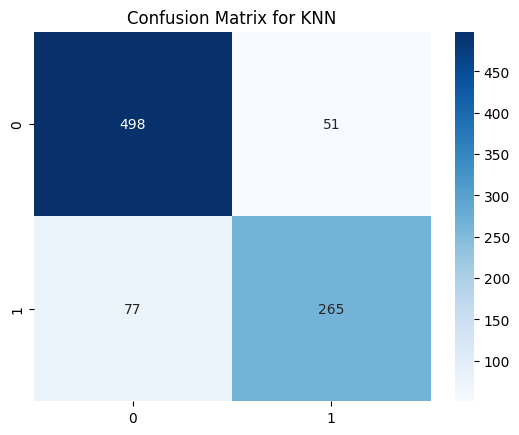

Classification Report for KNN
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       549
           1       0.84      0.77      0.81       342

    accuracy                           0.86       891
   macro avg       0.85      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891



In [83]:
# Confusion Matrix
cm_knn = confusion_matrix(y_train, train_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for KNN")
plt.show()

# Classification Report
print("Classification Report for KNN")
print(classification_report(y_train, train_pred_knn))


Compare KNN with Random Forest

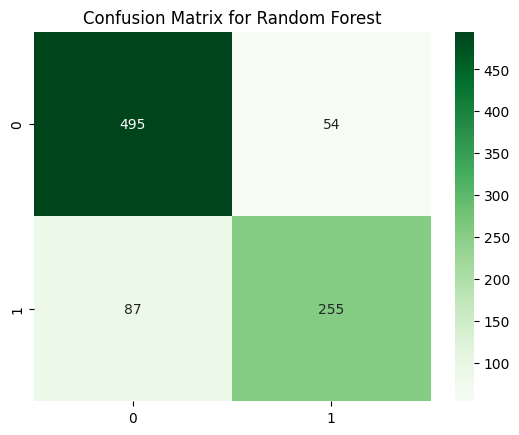

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       549
           1       0.83      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

KNN Accuracy: 85.63%
Random Forest Accuracy: 84.18%


In [84]:
# Random Forest Accuracy, Confusion Matrix, and Classification Report
train_pred_rf = random_forest.predict(x_train)
acc_random_forest = round(accuracy_score(y_train, train_pred_rf) * 100, 2)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_train, train_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix for Random Forest")
plt.show()

# Classification Report for Random Forest
print("Classification Report for Random Forest")
print(classification_report(y_train, train_pred_rf))

# Display both accuracies
print(f"KNN Accuracy: {acc_knn}%")
print(f"Random Forest Accuracy: {acc_random_forest}%")


Comparison between KNN and Random Forest:

Accuracy: Random Forest is generally expected to perform better on structured data with various features due to its ensemble nature. If Random Forest's accuracy is higher, it shows that combining multiple decision trees improves the model's prediction.
Confusion Matrix: Look at the confusion matrices for both models. If Random Forest has fewer false positives and false negatives, it means that it’s better at distinguishing between the two classes (e.g., survived vs. not survived in Titanic).
Classification Report: In the classification report, pay attention to precision, recall, and F1 score. Random Forest might have a higher F1 score because it balances precision and recall better, which can be important for datasets like Titanic where we want to avoid missing people who survived.
Which is better:

Random Forest: Likely to perform better because it’s robust to overfitting (thanks to averaging across multiple trees) and can handle feature importance. It’s typically better for datasets with many features or complex relationships.
KNN: Simple and intuitive but can be sensitive to noisy data and irrelevant features. It performs well on smaller datasets but can struggle with high-dimensional or large datasets due to the curse of dimensionality.
The model that fits best depends on the dataset's size, complexity, and feature relationships. You might find Random Forest performs better overall on the Titanic dataset due to its ability to capture non-linear relationships.